In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("diabetic_data.csv") # Lectura de los datos

# Exploración y preprocesamiento de datos

In [3]:
df.shape

(101766, 50)

Son en total 101766 registros con 50 variables, incluyendo la variable target que sería readmitted. Se busca predecir si un paciente no será readmitido, si será readmitido en menos de 30 días y si lo será luego de 30 días, desde su estadía en el hospital, considerando variable relacionadas con su salud, medicamentos, tiempo en el hospital.

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Variables y sus tipos.

In [5]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

Los valores faltantes '?' se reemplazarán con NaN

In [6]:
df = df.replace('?', np.nan)

La variable "encounter_id" no se considera relevante por ser un identificador único, "patient_nbr" tampoco, se eliminarán.

In [7]:
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

In [8]:
df.isna().sum() # Valores faltantes

race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

En el caso de la variable "weight" faltan más del 96% de los datos, entonces se borrará. Para "payer_code" faltan aproximadamente el 40% y como se refiere a las organizaciones que pagan la estadía no se considera muy relevante para el objetivo. Para "medical_specialty" falta aproximadamente el 50% de los datos, se considera que podría aportar pero al ser categórica, y faltar tantos registros, es complicado imputar los datos faltantes, inicialmente se borrará. Todos los demás registros con datos faltantes se eliminan por ser menos del 5%.

In [9]:
df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

In [10]:
df = df.dropna()
df = df[~(df.gender == 'Unknown/Invalid')]

### Transformación de diagnosticos

In [11]:
def transform(df,col):
    df.loc[df[col].str[0].isin(['E', 'V']), col] = 0
    
    df[col] = pd.to_numeric(df[col], errors='ignore')
    
    df['aux'] = np.nan
    
    df.loc[(df[col] >= 390) & (df[col] <= 459), 'aux'] = 'Circulatory'
    df.loc[(df[col]==785), 'aux'] = 'Circulatory'
    
    df.loc[(df[col] >= 460) & (df[col] <= 519), 'aux'] = 'Respiratory'
    df.loc[(df[col]==786), 'aux'] = 'Respiratory'
    
    df.loc[(df[col] >= 520) & (df[col] <= 579), 'aux'] = 'Digestive'
    df.loc[(df[col]==787), 'aux'] = 'Digestive'
    
    df.loc[(df[col] >= 800) & (df[col] <= 999), 'aux'] = 'Injury'
    
    df.loc[(df[col] >= 710) & (df[col] <= 739), 'aux'] = 'Musculoskeletal'
    
    df.loc[(df[col] >= 580) & (df[col] <= 629), 'aux'] = 'Genitourinary'
    df.loc[(df[col]==788), 'aux'] = 'Genitourinary'
    
    df.loc[(df[col] >= 140) & (df[col] <= 239), 'aux'] = 'Neoplasms'
    
    df.loc[(df[col] >= 250) & (df[col] < 251), 'aux'] = 'Diabetes'

    df['aux'] = df['aux'].fillna('Other')
    
    df.drop(col, axis=1, inplace = True)
    
    df.rename(columns={'aux':col}, inplace=True)

    return df


In [12]:
df = transform(df,'diag_1')
df = transform(df,'diag_2')
df = transform(df,'diag_3')

In [13]:
df.columns.values

array(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
       'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'diag_1', 'diag_2', 'diag_3'],
      dtype=object)

## Histogramas de todas las variables
Para observar como se distribuyen y ver a priori que efectos tienen las variables en la clasificación

<ipython-input-16-cdcf25515d14>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, sharey=True, sharex = True, constrained_layout=False)


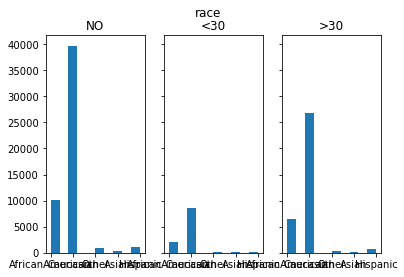

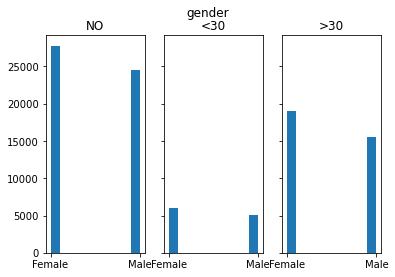

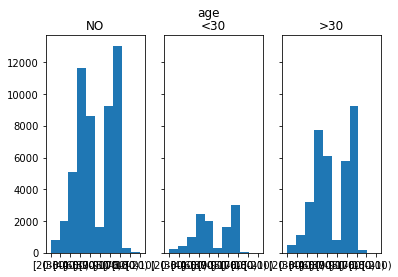

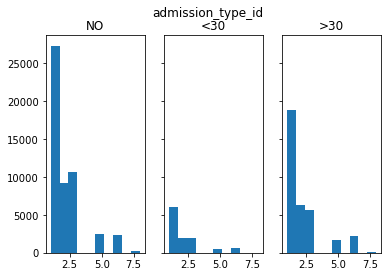

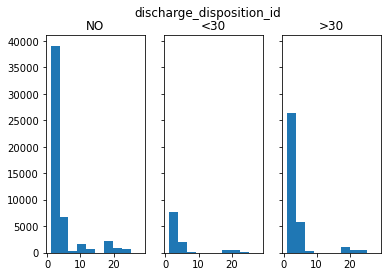

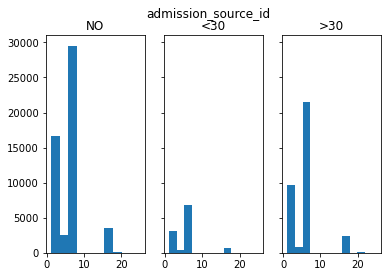

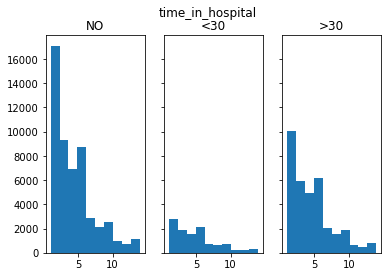

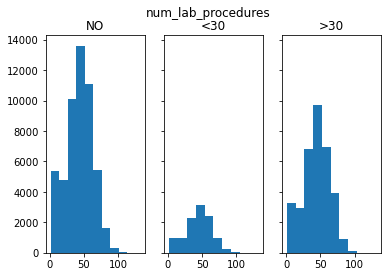

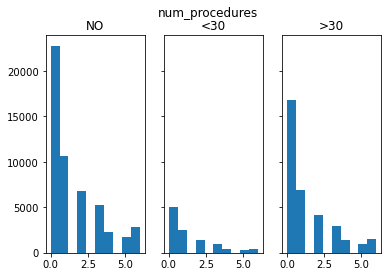

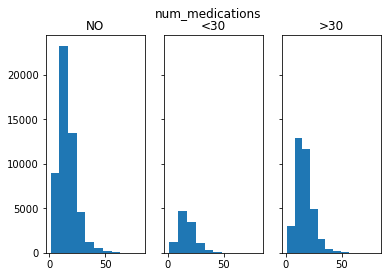

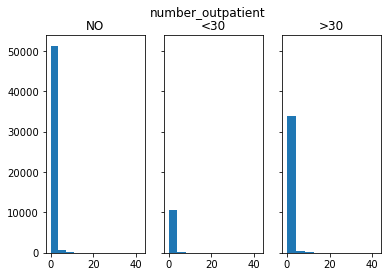

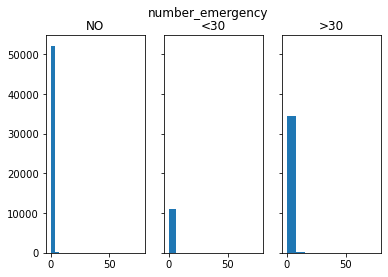

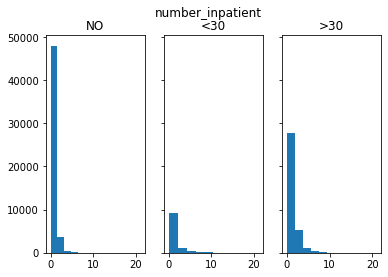

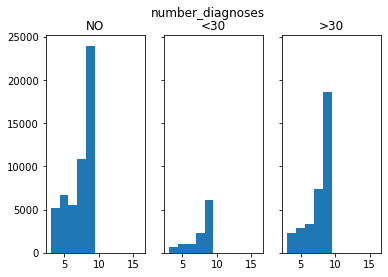

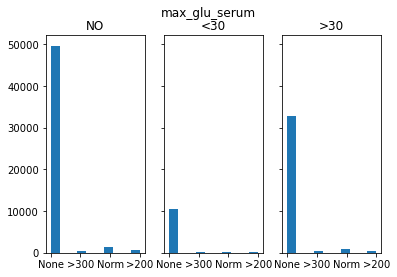

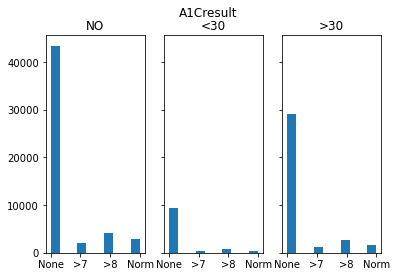

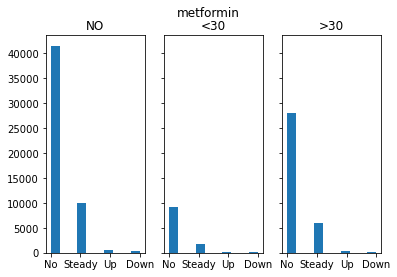

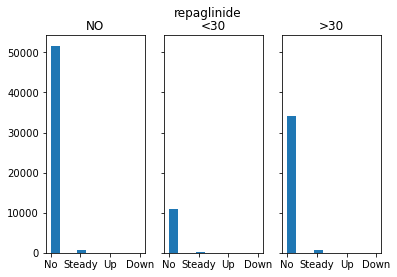

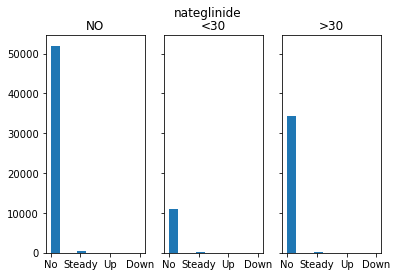

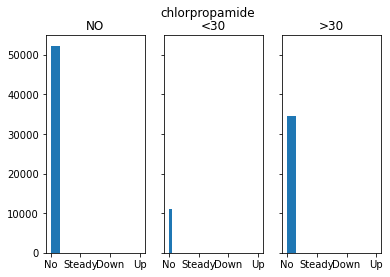

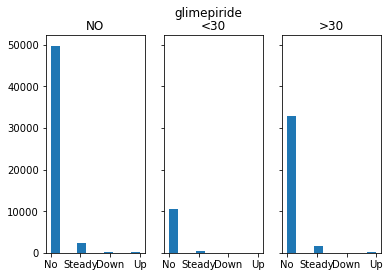

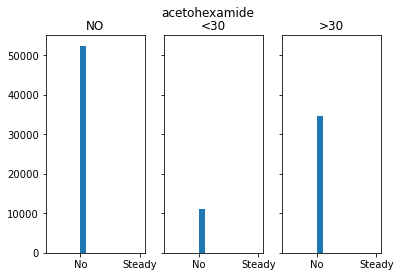

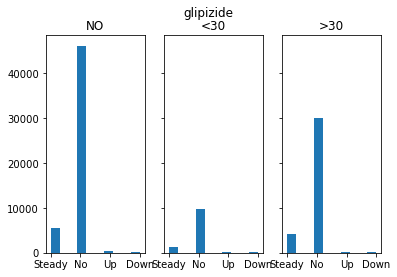

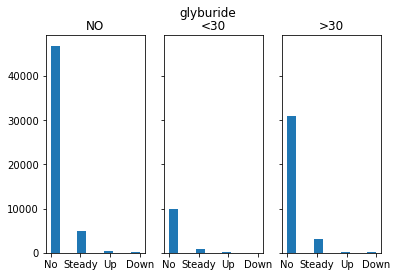

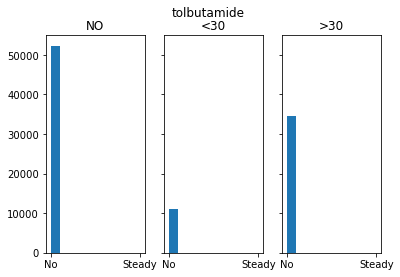

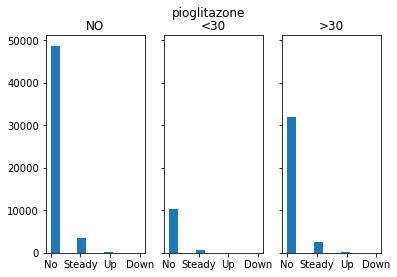

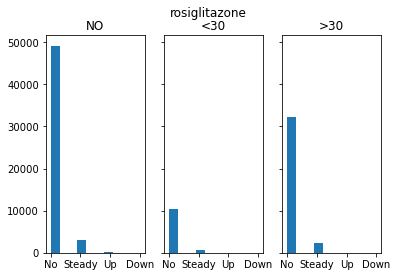

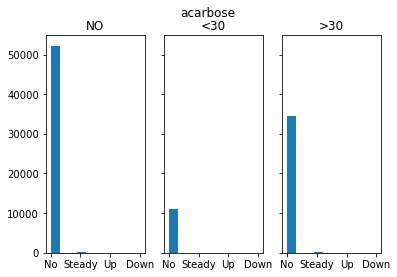

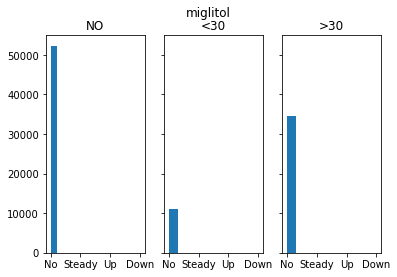

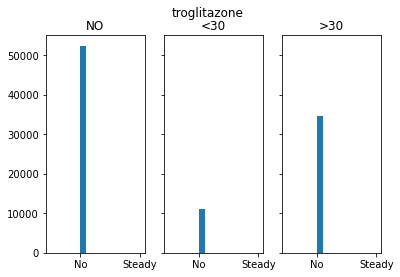

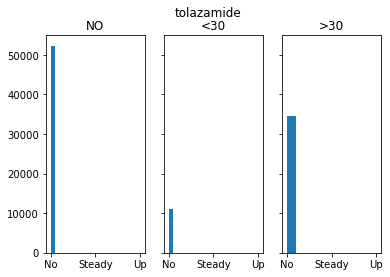

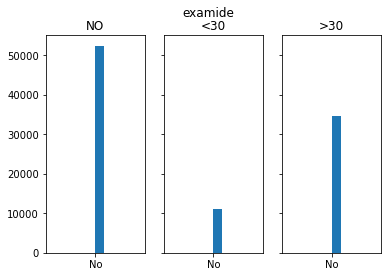

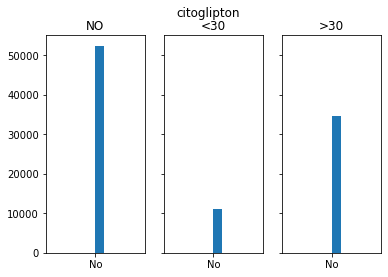

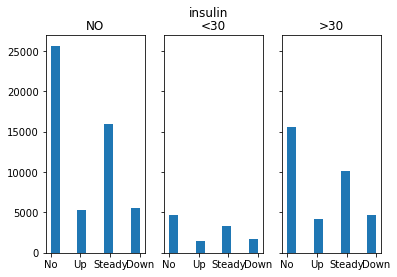

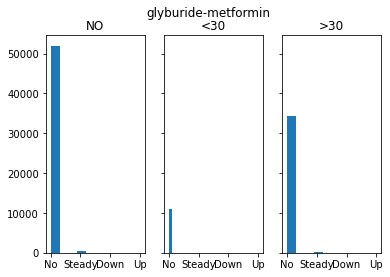

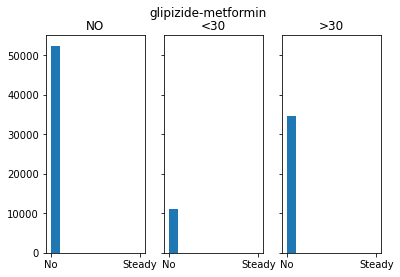

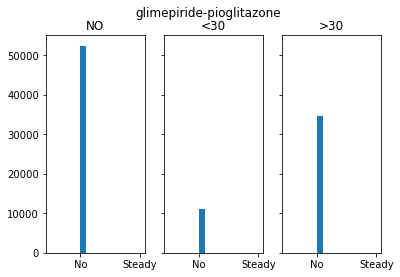

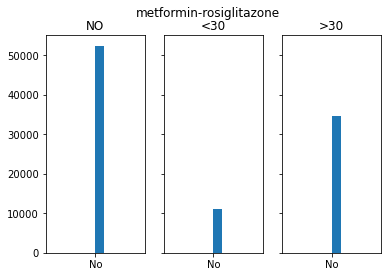

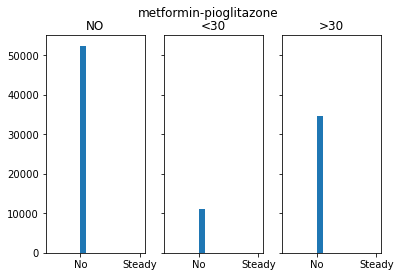

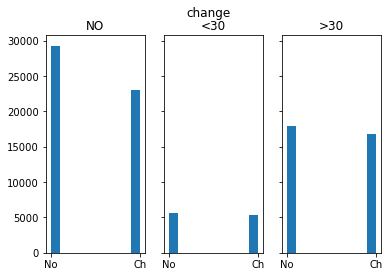

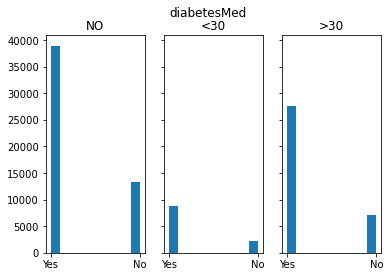

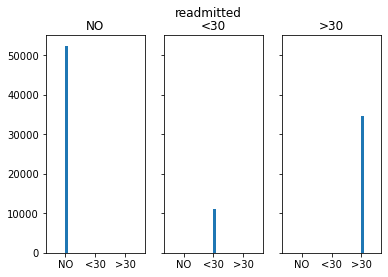

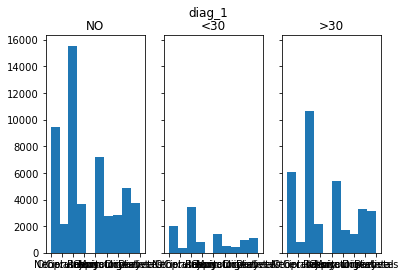

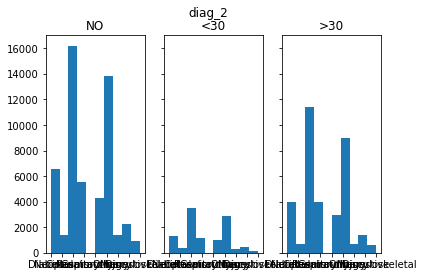

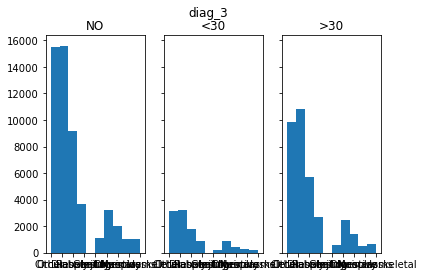

In [16]:
a = list(df.columns.values)

for column in a[0:len(a)]:
    fig, axs = plt.subplots(1, 3, sharey=True, sharex = True, constrained_layout=False)
    axs[0].hist(df[df.readmitted=='NO'][column])
    axs[1].hist(df[df.readmitted=='<30'][column])
    axs[2].hist(df[df.readmitted=='>30'][column])
    axs[0].set_title('NO')
    axs[1].set_title('<30')
    axs[2].set_title('>30')
    fig.suptitle(column)
